<a href="https://colab.research.google.com/github/neerajgoyal12/electoral_bonds/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
from pathlib import Path
import requests

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/neerajgoyal12/electoral_bonds/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

if Path("ec_data.csv").is_file():
  print("ec_data.csv already exists, skipping download")
else:
  print("Downloading ec_data.csv")
  request = requests.get("https://raw.githubusercontent.com/neerajgoyal12/electoral_bonds/main/data/ec_data.csv")
  with open("ec_data.csv", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download
ec_data.csv already exists, skipping download


In [113]:
df = pd.read_csv('ec_data.csv')

In [114]:
df.head(5)

,Date of Purchase,Purchaser Name,Denomination,Unnamed: 3
0,12/Apr/2019,A B C INDIA LIMITED,100000,NaN
1,12/Apr/2019,A B C INDIA LIMITED,100000,NaN
2,12/Apr/2019,A B C INDIA LIMITED,1000000,NaN
3,12/Apr/2019,A B C INDIA LIMITED,1000000,NaN
4,12/Apr/2019,A B C INDIA LIMITED,100000,NaN


In [115]:
df.tail(5)

,Date of Purchase,Purchaser Name,Denomination,Unnamed: 3
18866,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18867,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18868,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18869,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18870,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN


In [116]:
#dropping NaN column
df = df.dropna(axis = 1, how = 'all')
df

,Date of Purchase,Purchaser Name,Denomination
0,12/Apr/2019,A B C INDIA LIMITED,100000
1,12/Apr/2019,A B C INDIA LIMITED,100000
2,12/Apr/2019,A B C INDIA LIMITED,1000000
3,12/Apr/2019,A B C INDIA LIMITED,1000000
4,12/Apr/2019,A B C INDIA LIMITED,100000
...,...,...,...
18866,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18867,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18868,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18869,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000


In [117]:
# For future easy ness
dstr = 'Date of Purchase'
pnstr = 'Purchaser Name'
denostr = 'Denomination'

In [118]:
df.infer_objects()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date of Purchase  18871 non-null  object
 1   Purchaser Name    18871 non-null  object
 2   Denomination      18871 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 442.4+ KB


In [119]:
# Converting dtypes for later convenience
df[dstr] = pd.to_datetime(df[dstr])
df[pnstr] = df[pnstr].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date of Purchase  18871 non-null  datetime64[ns]
 1   Purchaser Name    18871 non-null  object        
 2   Denomination      18871 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 442.4+ KB


<ipython-input-119-388786a558fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dstr] = pd.to_datetime(df[dstr])
<ipython-input-119-388786a558fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pnstr] = df[pnstr].astype(str)


In [120]:
grouped_df = df.groupby(pnstr, sort=False).sum(numeric_only=True).copy()
grouped_df.reset_index(inplace=True)
grouped_df.sort_values(by=denostr, ascending=False, inplace=True)


In [121]:
# droppinf donners below 1 cr
above_1_cr_grouped_df = grouped_df[grouped_df[denostr] > 10000000].copy()
above_1_cr_grouped_df.tail()


,Purchaser Name,Denomination
767,ARUNANGSHU MUKHERJEE,11000000
1174,BHACHIBEN KHAMUBHAI MANVAR,10768000
1177,HARIJAN HIRIBAI,10768000
1185,RATHOD LAKHIBEN,10768000
65,RAIPUR BOTLING COMPANY,10001000


In [122]:
print(f"Highest Donation : {above_1_cr_grouped_df[denostr].max()}")
print(f"Lowest Donation : {above_1_cr_grouped_df[denostr].min()}")


Highest Donation : 12080000000
Lowest Donation : 10001000


In [123]:
# prompt: convert denomination to indian rupee in crore

above_1_cr_grouped_df[denostr] = above_1_cr_grouped_df[denostr] / 10000000
print(f"Total unique donors above 1cr: {len(above_1_cr_grouped_df)}")

Total unique donors above 1cr: 672


In [124]:
top_50_donors = above_1_cr_grouped_df.head(50).copy()
top_50_donors

,Purchaser Name,Denomination
339,FUTURE GAMING AND HOTEL SERVICES PR,1208.00
9,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,821.00
576,QWIKSUPPLYCHAINPRIVATELIMITED,410.00
161,HALDIA ENERGY LIMITED,377.00
77,VEDANTA LIMITED,375.65
4,ESSEL MINING AND INDS LTD,224.50
1145,WESTERN UP POWER TRANSMISSION COMPANY LI MITED,220.00
55,KEVENTER FOODPARK INFRA LIMITED,195.00
179,MADANLAL LTD.,185.50
361,BHARTI AIRTEL LIMITED,183.00


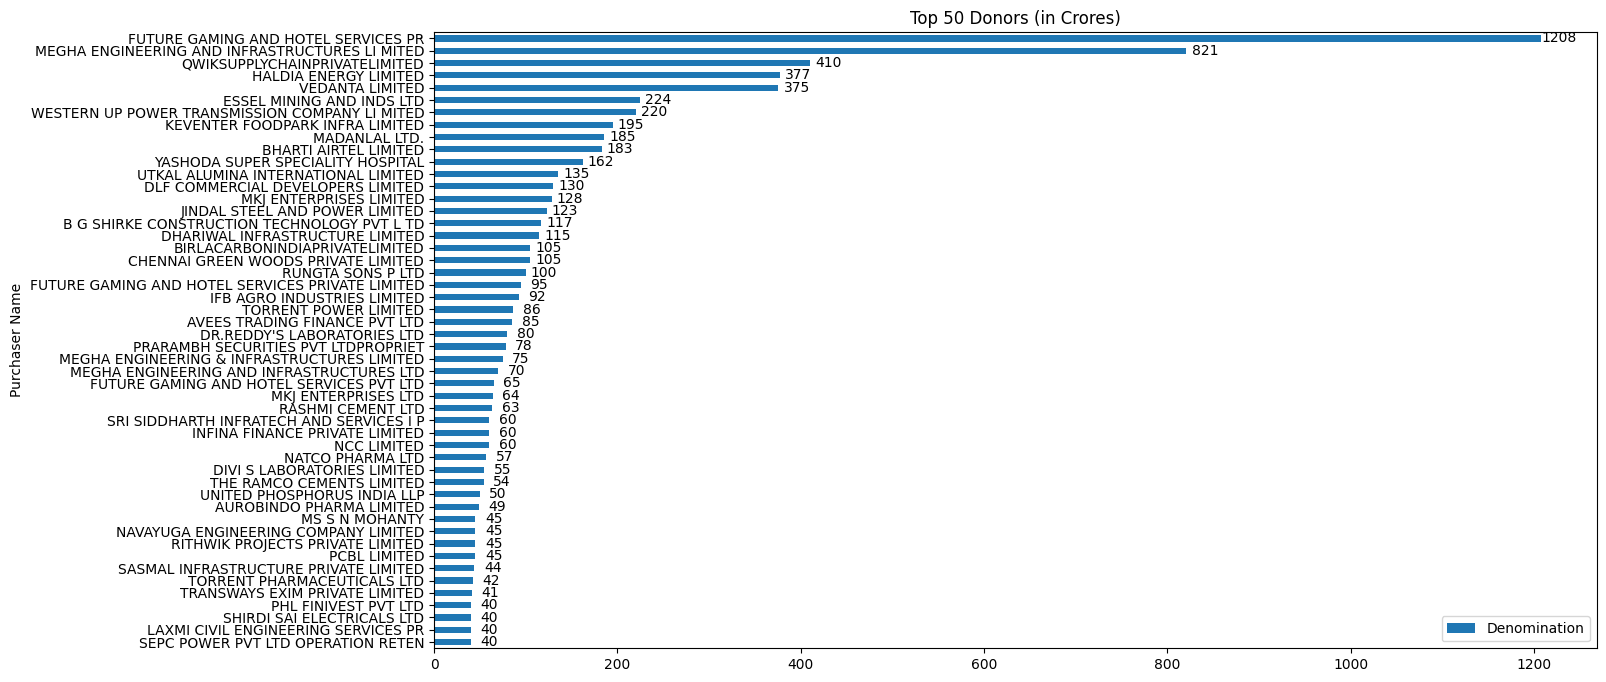

In [134]:
# prompt: hbar with lables for denomination on right of bar

import matplotlib.pyplot as plt

# Create the bar chart
ax = top_50_donors.plot.barh(x=pnstr, y=denostr)

# Add labels for the denominations on the right side of the bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height() / 2,
            str(int(bar.get_width())), ha='center', va='center')

# Invert the y-axis to show the highest values at the top
plt.gca().invert_yaxis()

# Add a title and show the plot
plt.title("Top 50 Donors (in Crores)")

import os

# Create the directory if it doesn't exist
if not os.path.exists('data'):
  os.makedirs('data')

# Save the figure
plt.savefig('data/top_50_donors_in_crore.png', bbox_inches='tight')
plt.show()